In [11]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from pyHalo.preset_models import CDM
from pyHalo import plotting_routines
from copy import deepcopy
from lenstronomy.Util.correlation import power_spectrum_1d

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import ft
from mejiro.utils import util
from mejiro.helpers import gs

Choose where to save

In [12]:
save_dir = os.path.join(array_dir, 'power_spectra')
util.create_directory_if_not_exists(save_dir)

# prepare directory for lenses
lens_dir = os.path.join(save_dir, 'lenses')
util.create_directory_if_not_exists(lens_dir)
util.clear_directory(lens_dir)

In [25]:
# collect lenses
num_lenses = 10
print(f'Collecting {num_lenses} lenses...')
pickled_lens_list = os.path.join(config.machine.dir_01, '01_hlwas_sim_detectable_lens_list')
lens_list = util.unpickle(pickled_lens_list)[:num_lenses]
pprint(lens_list)
print('Collected lenses.')

Collected lenses.


In [14]:
# set imaging params
bands = ['F106', 'F129', 'F184']
oversample = 1
num_pix = 45
side = 4.95

# set subhalo params
r_tidal = 0.5
sigma_sub = 0.055
subhalo_cone = 5
los_normalization = 0

In [15]:
lens = lens_list[0]

z_lens = round(lens.z_lens, 2)
z_source = round(lens.z_source, 2)
log_m_host = np.log10(lens.main_halo_mass)

In [16]:
cut_6 = CDM(z_lens,
            z_source,
            sigma_sub=sigma_sub,
            log_mlow=6.,
            log_mhigh=10.,
            log_m_host=log_m_host,
            r_tidal=r_tidal,
            cone_opening_angle_arcsec=subhalo_cone,
            LOS_normalization=los_normalization)

cut_7 = CDM(z_lens,
            z_source,
            sigma_sub=sigma_sub,
            log_mlow=7.,
            log_mhigh=10.,
            log_m_host=log_m_host,
            r_tidal=r_tidal,
            cone_opening_angle_arcsec=subhalo_cone,
            LOS_normalization=los_normalization)

cut_8 = CDM(z_lens,
            z_source,
            sigma_sub=sigma_sub,
            log_mlow=8.,
            log_mhigh=10.,
            log_m_host=log_m_host,
            r_tidal=r_tidal,
            cone_opening_angle_arcsec=subhalo_cone,
            LOS_normalization=los_normalization)

In [17]:
lens_cut_6 = deepcopy(lens)
lens_cut_7 = deepcopy(lens)
lens_cut_8 = deepcopy(lens)

lens_cut_6.add_subhalos(cut_6, suppress_output=True)
lens_cut_7.add_subhalos(cut_7, suppress_output=True)
lens_cut_8.add_subhalos(cut_8, suppress_output=True)

lenses = [lens, lens_cut_6, lens_cut_7, lens_cut_8]
titles = [f'lens_{lens.uid}_no_subhalos', f'lens_{lens.uid}_cut_6', f'lens_{lens.uid}_cut_7',
            f'lens_{lens.uid}_cut_8']

detectors = [4, 1, 9, 17]
detector_positions = [(4, 4092), (2048, 2048), (4, 4), (4092, 4092)]

In [18]:
for band in bands:
    # generate models
    models = [i.get_array(num_pix=num_pix * oversample, side=side, band=band) for i in lenses]

    for sl, model, title in tqdm(zip(lenses, models, titles), total=len(lenses)):
        for detector, detector_pos in zip(detectors, detector_positions):
            gs_images, _ = gs.get_images(sl, model, band, input_size=num_pix, output_size=num_pix,
                                        grid_oversample=oversample, psf_oversample=oversample,
                                        detector=detector, detector_pos=detector_pos, suppress_output=True)
            ps, r = power_spectrum_1d(gs_images[0])
            np.save(os.path.join(lens_dir, f'im_{title}_{band}_{detector}.npy'), gs_images[0])
            np.save(os.path.join(lens_dir, f'ps_{title}_{band}_{detector}.npy'), ps)
np.save(os.path.join(lens_dir, 'r.npy'), r)

  0%|          | 0/3 [00:00<?, ?it/s]

Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the ran

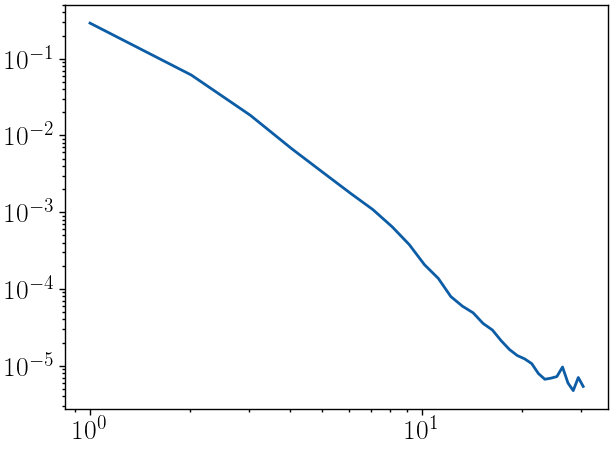

In [19]:
plt.loglog(r, ps)
plt.show()

In [20]:
for sl, model, title in tqdm(zip(lenses, models, titles), total=len(lenses)):
    # generate convergence maps
    if sl.realization is None:
        kappa = sl.get_macrolens_kappa(num_pix, subhalo_cone)
    else:
        kappa = sl.get_kappa(num_pix, subhalo_cone)
    kappa_power_spectrum, kappa_r = power_spectrum_1d(kappa)
    np.save(os.path.join(lens_dir, f'kappa_ps_{title}.npy'), kappa_power_spectrum)
np.save(os.path.join(lens_dir, 'kappa_r.npy'), kappa_r)

100%|██████████| 4/4 [00:00<00:00, 154.42it/s]


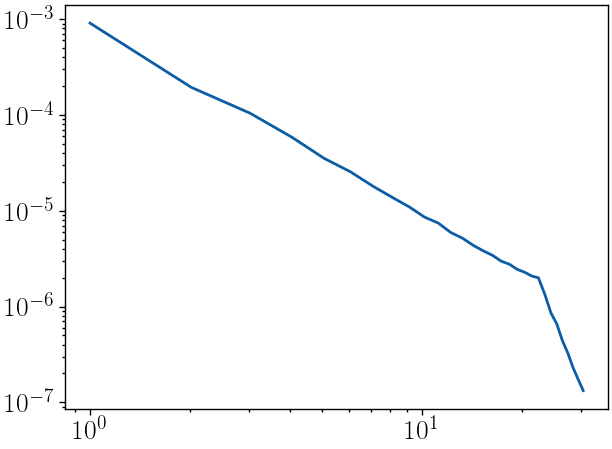

In [22]:
plt.loglog(kappa_r, kappa_power_spectrum)
plt.show()